# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [1]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image

random.seed(42)

### Connect Colab to Drive (if the dataset is on drive)

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#!unzip "drive/MyDrive/Dataset/images.zip" -d "."
#!cp "drive/MyDrive/Dataset/annotations.json" -d "."

In [44]:
# Define the model
# Define model
#weights = models.ResNet50_Weights.IMAGENET1K_V2
#model = models.resnet50(weights=weights)
#transforms = weights.transforms()
weights = models.ResNeXt101_32X8D_Weights.IMAGENET1K_V2
model = models.resnext101_32x8d(weights=False)
transforms1 = weights.transforms()

C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [30]:
# Normalize images
data_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomRotation(degrees=5),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_in = transforms1
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

'transforms.Compose([\n    transforms.ToImage(),\n    transforms.Resize((256, 256)),\n    transforms.CenterCrop((224, 224)),\n    transforms.ToDtype(torch.float32, scale=True),\n    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n])'

In [6]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    col = 7-col
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        #restrict ther the number of filenames to 10
        self.ids = np.asarray(self.ids)
        self.boards=torch.full((len(self.file_names), 8 * 8), 12)
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            piceId =int(piece['category_id'])
            self.boards[idx][row*8+col] = piceId
        #print(self.boards[0])
        if partition == 'train':#['chessred2k']
            self.split_ids = np.asarray(self.anns['splits']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.file_names = self.file_names#[:45]
        #self.boards = self.boards[self.split_ids]
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")
        self.images = {}
        for i in range(len(self.file_names)):
            #image = cv2.imread(os.path.join(self.root, self.file_names[i]))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.open(os.path.join(self.root, self.file_names[i]))
            if self.transform:
                image = self.transform(image)
            self.images[self.file_names[i]] = image

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = self.images[self.file_names[i]]

        board = self.boards[self.split_ids[i]]
        #print("Board shape:",board.shape)
        return image, board

train_dataset = ChessDataset('..', 'train', data_aug)
valid_dataset = ChessDataset('..', 'valid', data_in)
test_dataset = ChessDataset('..', 'test', data_in)

Number of train images: 6479
Number of valid images: 2192
Number of test images: 2129


In [48]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 8
num_workers = 0 # how many processes are used to load the data

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


In [23]:
def print_readable_board(labels):
    piece_dict = {
    0: "P",
    1: "R",
    2: "N",
    3: "B",
    4: "Q",
    5: "K",
    6: "p",
    7: "r",
    8: "n",
    9: "b",
    10:"q",
    11: "k",
    12: "-"
}
    for i in range(8):
        result_tmp = []
        for j in range(8):
            #print(labels[i*8+j].item())
            result_tmp.append(piece_dict[labels[i*8+j].item()])
        print(result_tmp)

['-', 'K', '-', '-', 'R', 'B', '-', '-']
['-', 'P', 'P', '-', '-', '-', '-', '-']
['P', '-', 'N', 'Q', 'R', '-', 'P', '-']
['-', '-', '-', '-', 'n', 'P', '-', '-']
['-', '-', '-', '-', '-', 'p', '-', 'p']
['-', 'p', '-', 'p', '-', '-', 'n', '-']
['p', 'b', 'p', '-', '-', 'q', 'p', '-']
['-', 'k', '-', '-', 'r', '-', '-', '-']


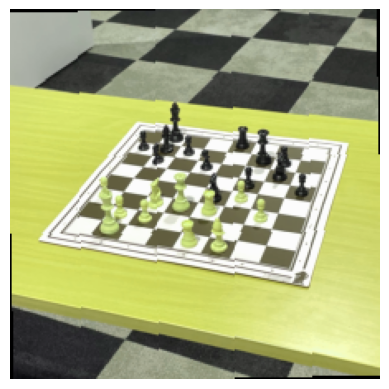

['R', 'N', 'B', 'K', 'Q', 'B', 'N', 'R']
['P', 'P', 'P', 'P', 'P', 'P', '-', 'P']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', 'P', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p']
['r', 'n', 'b', 'k', 'q', 'b', 'n', 'r']


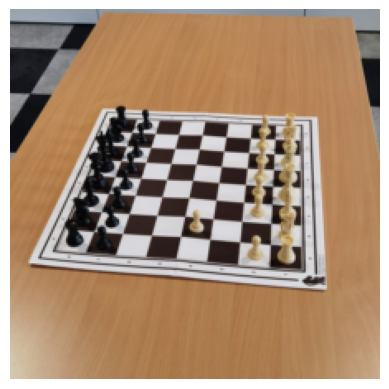

In [9]:
for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])

    # Get labels of each image in the batch and print them
    labels = batch[1]
    #print(labels[0].shape)
    #print(labels[0])
    print_readable_board(labels[0])
    #print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break
for batch in test_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    #print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    #print(labels[1])
    print_readable_board(labels[1])
    #print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[1])
    plt.axis('off')
    plt.show()

    break

## Defining the model

We will use a pre-trained ResNet50 network.

  1: white-pawn
  2: white-pawn
  3: white-pawn
  4: white-pawn
  5: white-pawn
  6: white-pawn
  7: white-pawn
  8: white-pawn
  9: white-rook
  10: white-rook
  11: white-knight
  12: white-knight
  13: white-bishop
  14: white-bishop
  15: white-queen
  16: white-king
  17: black-pawn
  18: black-pawn
  19: black-pawn
  20: black-pawn
  21: black-pawn
  22: black-pawn
  23: black-pawn
  24: black-pawn
  25: black-rook
  26: black-rook
  27: black-knight
  28: black-knight
  29: black-bishop
  30: black-bishop
  31: black-king
  32: black-queen
  12: empty

In [45]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


#for param in model:
#    param.requires_grad = False
# change the number of neurons in the last layer to the number of classes of the problem at hand (maximum number of pieces on a chess game)
# TODO
# MLP
size_parameters = 512
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.3),
    nn.Linear(512, 832)
    #nn.ReLU(),
    #nn.Linear(size_parameters, size_parameters),
    #nn.ReLU(),
    #nn.Linear(size_parameters, size_parameters),
    #nn.ReLU(),
    #nn.Linear(size_parameters, 64),
)
# black 
model.to(device)

Using cuda device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [32]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, f1_score,accuracy_score,recall_score,precision_score
def calculate_metrics(all_preds, all_labels):
    # claculate the accuracy of all the board
    accuracy_list = []
    for i in range(all_preds.shape[0]):
      #print("Test3",all_preds[i].shape)
      #print("\n")
      correct = (all_preds[i] == all_labels[i]).sum().item()
      total = all_labels[i].numel()
      #print((all_preds[i] == all_labels[i]))
      #print("Testing:",correct,"\nTotal:",total)
      accuracy_list.append(correct == total)
    accuracy = np.mean(accuracy_list)
    #for i in range(all_preds.shape[0]):
    all_preds = (all_preds.detach().numpy()).round().astype(int)
    all_labels = all_labels.detach().numpy().astype(int)
    #print("Test1 :",all_labels.flatten().shape, all_preds.flatten().shape)
    #print("Test1 :",all_labels.flatten(), all_preds.flatten())
    recall = recall_score(all_labels.flatten(), all_preds.flatten(), average='macro',zero_division=0)
    precision = precision_score(all_labels.flatten(), all_preds.flatten(), average='macro',zero_division=0)
    f1 = f1_score(all_labels.flatten(), all_preds.flatten(), average='macro',zero_division=0)
    recall1 = recall_score(all_labels.flatten(), all_preds.flatten(), average='micro',zero_division=0)
    precision1 = precision_score(all_labels.flatten(), all_preds.flatten(), average='micro',zero_division=0)
    f11 = f1_score(all_labels.flatten(), all_preds.flatten(), average='micro',zero_division=0)
    print(f"Micro: Recall: {recall1:.4f}, Precision: {precision1:.4f}, F1: {f11:.4f}")
    return accuracy, recall, precision, f1
def claculateMissMatchs(all_preds, all_labels):
    accuracyList = np.zeros(64, dtype=int)
    for i in range(all_preds.shape[0]):
      #print("Test3",all_preds[i].shape)
      #print("\n")
      correct = (all_preds[i] == all_labels[i]).sum().item()
      total = all_labels[i].numel()
      #print((all_preds[i] == all_labels[i]))
      #print("Testing:",correct,"\nTotal:",total)
      missmatched =total- correct
      accuracyList[missmatched] += 1
    return accuracyList

## Train the model

Define function to perform one iteration

In [33]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, f1_score,accuracy_score

def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device) # remove the last dimension
        
          # Compute prediction error
          
          pred = model(X)
          scaled_pred = (pred).view(-1, 8, 8, 13)

          #scaled_pred = model(X)
          #print(scaled_pred.shape,y.shape)
          #print(scaled_pred,y)
          pred_loss = scaled_pred.permute(0, 3, 1, 2)
          #print("Pred shape:",pred_loss.shape,y.view( -1,8, 8).shape)
          loss = loss_fn( pred_loss, y.view( -1,8, 8))
          #print("Scaled pred shape:",scaled_pred)
          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached
          #print("Test metrics:",scaled_pred.argmax(dim=-1).view( -1, 64).shape)
          preds.append(scaled_pred.argmax(dim=-1).view( -1, 64).cpu())
          #print(preds)
          #print(final_pred.cpu().numpy())
          #original_values =y.cpu().argmax(dim=-1) + 1
          labels.append(y.cpu())
    all_preds = torch.cat(preds).round()
    all_labels = torch.cat(labels)
    #print("All preds shape:",all_preds.shape)
    #print("All labels shape:",all_labels.shape)
    accuracy, recall, precision, f1 = calculate_metrics(all_preds, all_labels)
    #print("Mean Correct: :",matches)
    """print(all_preds.shape,all_labels.shape)
    print(all_preds,all_labels)
      # Calculate exact match accuracy (PyTorch way)
    exact_matches = (all_preds == all_labels).all(dim=1).float().mean().item()
    
    # Calculate element-wise accuracy
    element_acc = (all_preds == all_labels).float().mean().item()
    print(exact_matches,element_acc)"""
    
    return total_loss / num_batches, accuracy, recall, precision, f1

Define function to train a model

In [38]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'accuracy': [], 'recall':[], 'precision': [], 'f1': []}
  val_history = {'loss': [], 'accuracy': [], 'recall':[], 'precision': [], 'f1': []}
  best_val_loss = np.inf
  trigger_times = 0
  best_val_loss = float('inf')
  patience = 10  # Chess models often need longer to converge
  min_delta = 0.0001  # Minimum improvement to reset patience
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss, train_acc,train_recall,train_precision,train_f1 = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.5f} \t Train acc: {train_acc:.5f} \t Train recall: {train_recall:.5f} \t Train precision: {train_precision:.5f} \t Train f1: {train_f1:.5f}")
      val_loss, val_acc,val_recall,val_precision,val_f1 = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.5f} \t Val acc: {val_acc:.5f} \t Val recall: {val_recall:.5f} \t Val precision: {val_precision:.5f} \t Val f1: {val_f1:.5f}")


      # Early stoping
      if val_loss < (best_val_loss - min_delta):
          best_val_loss = val_loss
          trigger_times = 0
      else:
          trigger_times += 1
          if trigger_times >= patience:
              print("Early stopping!")
              break
      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)
      train_history["recall"].append(train_recall)
      train_history["precision"].append(train_precision)
      train_history["f1"].append(train_f1)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)
      val_history["recall"].append(val_recall)
      val_history["precision"].append(val_precision)
      val_history["f1"].append(val_f1)
      
  print("Finished")
  return train_history, val_history

Define loss, optimizer and train the model

In [39]:
# Define loss function
loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.MSELoss()
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
num_epochs = 200

# TODO - Train the model
train_history, val_history = train(model, 'chess_model', num_epochs, train_dataloader, valid_dataloader, loss_fn, optimizer)

Start training...

Epoch 1


100%|██████████| 809/809 [03:17<00:00,  4.09it/s]


Micro: Recall: 0.6701, Precision: 0.6701, F1: 0.6701
Train loss: 1.03527 	 Train acc: 0.00000 	 Train recall: 0.14661 	 Train precision: 0.34590 	 Train f1: 0.17130


100%|██████████| 274/274 [00:15<00:00, 17.55it/s]


Micro: Recall: 0.7007, Precision: 0.7007, F1: 0.7007
Val loss: 1.02802 	 Val acc: 0.00000 	 Val recall: 0.22702 	 Val precision: 0.44056 	 Val f1: 0.26170

Epoch 2


100%|██████████| 809/809 [03:17<00:00,  4.10it/s]


Micro: Recall: 0.7079, Precision: 0.7079, F1: 0.7079
Train loss: 0.91355 	 Train acc: 0.00000 	 Train recall: 0.28735 	 Train precision: 0.56831 	 Train f1: 0.36321


100%|██████████| 274/274 [00:15<00:00, 17.64it/s]


Micro: Recall: 0.7570, Precision: 0.7570, F1: 0.7570
Val loss: 0.83162 	 Val acc: 0.00684 	 Val recall: 0.32945 	 Val precision: 0.73287 	 Val f1: 0.43108

Epoch 3


100%|██████████| 809/809 [03:18<00:00,  4.09it/s]


Micro: Recall: 0.7243, Precision: 0.7243, F1: 0.7243
Train loss: 0.85655 	 Train acc: 0.00108 	 Train recall: 0.32864 	 Train precision: 0.64154 	 Train f1: 0.41714


100%|██████████| 274/274 [00:15<00:00, 17.59it/s]


Micro: Recall: 0.7615, Precision: 0.7615, F1: 0.7615
Val loss: 0.80947 	 Val acc: 0.00547 	 Val recall: 0.34180 	 Val precision: 0.75713 	 Val f1: 0.44823

Epoch 4


100%|██████████| 809/809 [03:18<00:00,  4.08it/s]


Micro: Recall: 0.7338, Precision: 0.7338, F1: 0.7338
Train loss: 0.82316 	 Train acc: 0.00077 	 Train recall: 0.34583 	 Train precision: 0.66326 	 Train f1: 0.43711


100%|██████████| 274/274 [00:15<00:00, 17.69it/s]


Micro: Recall: 0.7314, Precision: 0.7314, F1: 0.7314
Val loss: 0.87700 	 Val acc: 0.00137 	 Val recall: 0.33911 	 Val precision: 0.73110 	 Val f1: 0.43654

Epoch 5


100%|██████████| 809/809 [03:18<00:00,  4.08it/s]


Micro: Recall: 0.7466, Precision: 0.7466, F1: 0.7466
Train loss: 0.78347 	 Train acc: 0.00216 	 Train recall: 0.36613 	 Train precision: 0.69759 	 Train f1: 0.46236


100%|██████████| 274/274 [00:15<00:00, 17.64it/s]


Micro: Recall: 0.7717, Precision: 0.7717, F1: 0.7717
Val loss: 0.78152 	 Val acc: 0.00958 	 Val recall: 0.38892 	 Val precision: 0.75855 	 Val f1: 0.49625

Epoch 6


100%|██████████| 809/809 [03:18<00:00,  4.08it/s]


Micro: Recall: 0.7572, Precision: 0.7572, F1: 0.7572
Train loss: 0.75398 	 Train acc: 0.00232 	 Train recall: 0.38076 	 Train precision: 0.72317 	 Train f1: 0.48049


100%|██████████| 274/274 [00:15<00:00, 17.92it/s]


Micro: Recall: 0.7712, Precision: 0.7712, F1: 0.7712
Val loss: 0.78498 	 Val acc: 0.00639 	 Val recall: 0.39800 	 Val precision: 0.76014 	 Val f1: 0.50343

Epoch 7


100%|██████████| 809/809 [03:15<00:00,  4.13it/s]


Micro: Recall: 0.7676, Precision: 0.7676, F1: 0.7676
Train loss: 0.72437 	 Train acc: 0.00324 	 Train recall: 0.39612 	 Train precision: 0.74507 	 Train f1: 0.49894


100%|██████████| 274/274 [00:15<00:00, 18.14it/s]


Micro: Recall: 0.7772, Precision: 0.7772, F1: 0.7772
Val loss: 0.77003 	 Val acc: 0.00000 	 Val recall: 0.36747 	 Val precision: 0.80099 	 Val f1: 0.47884

Epoch 8


100%|██████████| 809/809 [03:16<00:00,  4.11it/s]


Micro: Recall: 0.7783, Precision: 0.7783, F1: 0.7783
Train loss: 0.69482 	 Train acc: 0.00340 	 Train recall: 0.41373 	 Train precision: 0.76260 	 Train f1: 0.51821


100%|██████████| 274/274 [00:15<00:00, 18.12it/s]


Micro: Recall: 0.7833, Precision: 0.7833, F1: 0.7833
Val loss: 0.74587 	 Val acc: 0.00228 	 Val recall: 0.38334 	 Val precision: 0.82022 	 Val f1: 0.49945

Epoch 9


100%|██████████| 809/809 [03:18<00:00,  4.09it/s]


Micro: Recall: 0.7916, Precision: 0.7916, F1: 0.7916
Train loss: 0.66236 	 Train acc: 0.00479 	 Train recall: 0.43184 	 Train precision: 0.78239 	 Train f1: 0.53824


100%|██████████| 274/274 [00:15<00:00, 18.02it/s]


Micro: Recall: 0.7946, Precision: 0.7946, F1: 0.7946
Val loss: 0.72340 	 Val acc: 0.00502 	 Val recall: 0.41009 	 Val precision: 0.81681 	 Val f1: 0.52334

Epoch 10


100%|██████████| 809/809 [03:15<00:00,  4.13it/s]


Micro: Recall: 0.8044, Precision: 0.8044, F1: 0.8044
Train loss: 0.62799 	 Train acc: 0.00464 	 Train recall: 0.45062 	 Train precision: 0.79741 	 Train f1: 0.55776


100%|██████████| 274/274 [00:15<00:00, 18.07it/s]


Micro: Recall: 0.8066, Precision: 0.8066, F1: 0.8066
Val loss: 0.69040 	 Val acc: 0.00365 	 Val recall: 0.43842 	 Val precision: 0.83592 	 Val f1: 0.55559

Epoch 11


100%|██████████| 809/809 [03:17<00:00,  4.10it/s]


Micro: Recall: 0.8182, Precision: 0.8182, F1: 0.8182
Train loss: 0.59085 	 Train acc: 0.00603 	 Train recall: 0.47526 	 Train precision: 0.81432 	 Train f1: 0.58285


100%|██████████| 274/274 [00:15<00:00, 17.94it/s]


Micro: Recall: 0.8194, Precision: 0.8194, F1: 0.8194
Val loss: 0.66732 	 Val acc: 0.00867 	 Val recall: 0.45309 	 Val precision: 0.84239 	 Val f1: 0.57074

Epoch 12


100%|██████████| 809/809 [03:17<00:00,  4.10it/s]


Micro: Recall: 0.8303, Precision: 0.8303, F1: 0.8303
Train loss: 0.55749 	 Train acc: 0.00834 	 Train recall: 0.49577 	 Train precision: 0.82895 	 Train f1: 0.60372


100%|██████████| 274/274 [00:14<00:00, 18.28it/s]


Micro: Recall: 0.8196, Precision: 0.8196, F1: 0.8196
Val loss: 0.65546 	 Val acc: 0.00912 	 Val recall: 0.44690 	 Val precision: 0.85303 	 Val f1: 0.56729

Epoch 13


100%|██████████| 809/809 [03:16<00:00,  4.11it/s]


Micro: Recall: 0.8417, Precision: 0.8417, F1: 0.8417
Train loss: 0.52619 	 Train acc: 0.01190 	 Train recall: 0.51574 	 Train precision: 0.84091 	 Train f1: 0.62311


100%|██████████| 274/274 [00:15<00:00, 18.01it/s]


Micro: Recall: 0.8308, Precision: 0.8308, F1: 0.8308
Val loss: 0.62745 	 Val acc: 0.01186 	 Val recall: 0.48189 	 Val precision: 0.83365 	 Val f1: 0.59450

Epoch 14


100%|██████████| 809/809 [03:16<00:00,  4.11it/s]


Micro: Recall: 0.8514, Precision: 0.8514, F1: 0.8514
Train loss: 0.49705 	 Train acc: 0.01190 	 Train recall: 0.53594 	 Train precision: 0.85038 	 Train f1: 0.64215


100%|██████████| 274/274 [00:15<00:00, 18.01it/s]


Micro: Recall: 0.8338, Precision: 0.8338, F1: 0.8338
Val loss: 0.61579 	 Val acc: 0.01642 	 Val recall: 0.49296 	 Val precision: 0.82174 	 Val f1: 0.60137

Epoch 15


100%|██████████| 809/809 [03:15<00:00,  4.14it/s]


Micro: Recall: 0.8598, Precision: 0.8598, F1: 0.8598
Train loss: 0.47176 	 Train acc: 0.01422 	 Train recall: 0.55446 	 Train precision: 0.85662 	 Train f1: 0.65881


100%|██████████| 274/274 [00:15<00:00, 18.10it/s]


Micro: Recall: 0.8443, Precision: 0.8443, F1: 0.8443
Val loss: 0.58543 	 Val acc: 0.03057 	 Val recall: 0.51128 	 Val precision: 0.81813 	 Val f1: 0.61332

Epoch 16


100%|██████████| 809/809 [03:16<00:00,  4.12it/s]


Micro: Recall: 0.8675, Precision: 0.8675, F1: 0.8675
Train loss: 0.45071 	 Train acc: 0.01823 	 Train recall: 0.56940 	 Train precision: 0.86618 	 Train f1: 0.67317


100%|██████████| 274/274 [00:15<00:00, 18.08it/s]


Micro: Recall: 0.8535, Precision: 0.8535, F1: 0.8535
Val loss: 0.56056 	 Val acc: 0.03102 	 Val recall: 0.52240 	 Val precision: 0.83474 	 Val f1: 0.62776

Epoch 17


100%|██████████| 809/809 [03:15<00:00,  4.13it/s]


Micro: Recall: 0.8761, Precision: 0.8761, F1: 0.8761
Train loss: 0.42619 	 Train acc: 0.01823 	 Train recall: 0.58974 	 Train precision: 0.87121 	 Train f1: 0.69066


100%|██████████| 274/274 [00:15<00:00, 18.16it/s]


Micro: Recall: 0.8589, Precision: 0.8589, F1: 0.8589
Val loss: 0.54374 	 Val acc: 0.02828 	 Val recall: 0.53377 	 Val precision: 0.82963 	 Val f1: 0.63624

Epoch 18


100%|██████████| 809/809 [03:16<00:00,  4.12it/s]


Micro: Recall: 0.8834, Precision: 0.8834, F1: 0.8834
Train loss: 0.40386 	 Train acc: 0.02086 	 Train recall: 0.60611 	 Train precision: 0.87956 	 Train f1: 0.70556


100%|██████████| 274/274 [00:15<00:00, 18.15it/s]


Micro: Recall: 0.8589, Precision: 0.8589, F1: 0.8589
Val loss: 0.54132 	 Val acc: 0.02464 	 Val recall: 0.52079 	 Val precision: 0.83191 	 Val f1: 0.62642

Epoch 19


100%|██████████| 809/809 [03:16<00:00,  4.12it/s]


Micro: Recall: 0.8894, Precision: 0.8894, F1: 0.8894
Train loss: 0.38529 	 Train acc: 0.02210 	 Train recall: 0.62145 	 Train precision: 0.88388 	 Train f1: 0.71855


100%|██████████| 274/274 [00:15<00:00, 18.03it/s]


Micro: Recall: 0.8704, Precision: 0.8704, F1: 0.8704
Val loss: 0.50875 	 Val acc: 0.03467 	 Val recall: 0.54382 	 Val precision: 0.84896 	 Val f1: 0.64838

Epoch 20


100%|██████████| 809/809 [03:16<00:00,  4.12it/s]


Micro: Recall: 0.8954, Precision: 0.8954, F1: 0.8954
Train loss: 0.36803 	 Train acc: 0.02040 	 Train recall: 0.63795 	 Train precision: 0.88763 	 Train f1: 0.73206


100%|██████████| 274/274 [00:15<00:00, 18.15it/s]


Micro: Recall: 0.8720, Precision: 0.8720, F1: 0.8720
Val loss: 0.49810 	 Val acc: 0.03330 	 Val recall: 0.55042 	 Val precision: 0.84319 	 Val f1: 0.65211

Epoch 21


100%|██████████| 809/809 [03:15<00:00,  4.13it/s]


Micro: Recall: 0.8998, Precision: 0.8998, F1: 0.8998
Train loss: 0.35204 	 Train acc: 0.02333 	 Train recall: 0.64939 	 Train precision: 0.88742 	 Train f1: 0.74053


100%|██████████| 274/274 [00:15<00:00, 18.08it/s]


Micro: Recall: 0.8810, Precision: 0.8810, F1: 0.8810
Val loss: 0.47090 	 Val acc: 0.04197 	 Val recall: 0.56614 	 Val precision: 0.83876 	 Val f1: 0.66411

Epoch 22


100%|██████████| 809/809 [03:16<00:00,  4.13it/s]


Micro: Recall: 0.9041, Precision: 0.9041, F1: 0.9041
Train loss: 0.33927 	 Train acc: 0.02379 	 Train recall: 0.66040 	 Train precision: 0.89228 	 Train f1: 0.74990


100%|██████████| 274/274 [00:15<00:00, 18.18it/s]


Micro: Recall: 0.8826, Precision: 0.8826, F1: 0.8826
Val loss: 0.45768 	 Val acc: 0.04015 	 Val recall: 0.56360 	 Val precision: 0.84839 	 Val f1: 0.66473

Epoch 23


100%|██████████| 809/809 [03:15<00:00,  4.13it/s]


Micro: Recall: 0.9082, Precision: 0.9082, F1: 0.9082
Train loss: 0.32840 	 Train acc: 0.02781 	 Train recall: 0.67124 	 Train precision: 0.89601 	 Train f1: 0.75893


100%|██████████| 274/274 [00:15<00:00, 18.04it/s]


Micro: Recall: 0.8830, Precision: 0.8830, F1: 0.8830
Val loss: 0.45324 	 Val acc: 0.03604 	 Val recall: 0.56292 	 Val precision: 0.84356 	 Val f1: 0.66377

Epoch 24


100%|██████████| 809/809 [03:14<00:00,  4.16it/s]


Micro: Recall: 0.9109, Precision: 0.9109, F1: 0.9109
Train loss: 0.31907 	 Train acc: 0.02596 	 Train recall: 0.68062 	 Train precision: 0.89485 	 Train f1: 0.76535


100%|██████████| 274/274 [00:15<00:00, 18.25it/s]


Micro: Recall: 0.8882, Precision: 0.8882, F1: 0.8882
Val loss: 0.44274 	 Val acc: 0.04060 	 Val recall: 0.56667 	 Val precision: 0.86376 	 Val f1: 0.67029

Epoch 25


100%|██████████| 809/809 [03:15<00:00,  4.13it/s]


Micro: Recall: 0.9163, Precision: 0.9163, F1: 0.9163
Train loss: 0.30478 	 Train acc: 0.03044 	 Train recall: 0.69439 	 Train precision: 0.90068 	 Train f1: 0.77686


100%|██████████| 274/274 [00:15<00:00, 18.19it/s]


Micro: Recall: 0.8937, Precision: 0.8937, F1: 0.8937
Val loss: 0.42233 	 Val acc: 0.04927 	 Val recall: 0.58618 	 Val precision: 0.83308 	 Val f1: 0.67669

Epoch 26


100%|██████████| 809/809 [03:15<00:00,  4.14it/s]


Micro: Recall: 0.9178, Precision: 0.9178, F1: 0.9178
Train loss: 0.29867 	 Train acc: 0.03183 	 Train recall: 0.69949 	 Train precision: 0.90165 	 Train f1: 0.78064


100%|██████████| 274/274 [00:15<00:00, 18.17it/s]


Micro: Recall: 0.8984, Precision: 0.8984, F1: 0.8984
Val loss: 0.41358 	 Val acc: 0.05338 	 Val recall: 0.60047 	 Val precision: 0.80396 	 Val f1: 0.67801

Epoch 27


100%|██████████| 809/809 [03:16<00:00,  4.12it/s]


Micro: Recall: 0.9213, Precision: 0.9213, F1: 0.9213
Train loss: 0.28995 	 Train acc: 0.03214 	 Train recall: 0.70776 	 Train precision: 0.90513 	 Train f1: 0.78751


100%|██████████| 274/274 [00:14<00:00, 18.33it/s]


Micro: Recall: 0.8992, Precision: 0.8992, F1: 0.8992
Val loss: 0.40108 	 Val acc: 0.04927 	 Val recall: 0.59264 	 Val precision: 0.81915 	 Val f1: 0.67741

Epoch 28


100%|██████████| 809/809 [03:16<00:00,  4.12it/s]


Micro: Recall: 0.9231, Precision: 0.9231, F1: 0.9231
Train loss: 0.28347 	 Train acc: 0.03152 	 Train recall: 0.71444 	 Train precision: 0.90580 	 Train f1: 0.79224


100%|██████████| 274/274 [00:14<00:00, 18.32it/s]


Micro: Recall: 0.9019, Precision: 0.9019, F1: 0.9019
Val loss: 0.39455 	 Val acc: 0.05292 	 Val recall: 0.59942 	 Val precision: 0.81896 	 Val f1: 0.68213

Epoch 29


100%|██████████| 809/809 [03:15<00:00,  4.13it/s]


Micro: Recall: 0.9241, Precision: 0.9241, F1: 0.9241
Train loss: 0.27979 	 Train acc: 0.03322 	 Train recall: 0.71800 	 Train precision: 0.90464 	 Train f1: 0.79440


100%|██████████| 274/274 [00:15<00:00, 18.12it/s]


Micro: Recall: 0.8987, Precision: 0.8987, F1: 0.8987
Val loss: 0.40224 	 Val acc: 0.04790 	 Val recall: 0.58562 	 Val precision: 0.84074 	 Val f1: 0.67803

Epoch 30


100%|██████████| 809/809 [03:15<00:00,  4.13it/s]


Micro: Recall: 0.9273, Precision: 0.9273, F1: 0.9273
Train loss: 0.27162 	 Train acc: 0.03770 	 Train recall: 0.72748 	 Train precision: 0.90949 	 Train f1: 0.80243


100%|██████████| 274/274 [00:15<00:00, 18.19it/s]


Micro: Recall: 0.9043, Precision: 0.9043, F1: 0.9043
Val loss: 0.38421 	 Val acc: 0.05703 	 Val recall: 0.59711 	 Val precision: 0.82283 	 Val f1: 0.68113

Epoch 31


100%|██████████| 809/809 [03:15<00:00,  4.13it/s]


Micro: Recall: 0.9267, Precision: 0.9267, F1: 0.9267
Train loss: 0.27293 	 Train acc: 0.03337 	 Train recall: 0.72675 	 Train precision: 0.90743 	 Train f1: 0.80116


100%|██████████| 274/274 [00:15<00:00, 18.18it/s]


Micro: Recall: 0.9055, Precision: 0.9055, F1: 0.9055
Val loss: 0.38190 	 Val acc: 0.05474 	 Val recall: 0.60975 	 Val precision: 0.80699 	 Val f1: 0.68610

Epoch 32


100%|██████████| 809/809 [03:14<00:00,  4.17it/s]


Micro: Recall: 0.9295, Precision: 0.9295, F1: 0.9295
Train loss: 0.26482 	 Train acc: 0.04002 	 Train recall: 0.73379 	 Train precision: 0.90961 	 Train f1: 0.80655


100%|██████████| 274/274 [00:15<00:00, 18.13it/s]


Micro: Recall: 0.9100, Precision: 0.9100, F1: 0.9100
Val loss: 0.37153 	 Val acc: 0.06250 	 Val recall: 0.62141 	 Val precision: 0.80056 	 Val f1: 0.69132

Epoch 33


100%|██████████| 809/809 [03:15<00:00,  4.14it/s]


Micro: Recall: 0.9315, Precision: 0.9315, F1: 0.9315
Train loss: 0.26076 	 Train acc: 0.03863 	 Train recall: 0.73936 	 Train precision: 0.91241 	 Train f1: 0.81111


100%|██████████| 274/274 [00:15<00:00, 18.04it/s]


Micro: Recall: 0.9087, Precision: 0.9087, F1: 0.9087
Val loss: 0.36677 	 Val acc: 0.05657 	 Val recall: 0.60971 	 Val precision: 0.82583 	 Val f1: 0.69090

Epoch 34


100%|██████████| 809/809 [03:16<00:00,  4.12it/s]


Micro: Recall: 0.9324, Precision: 0.9324, F1: 0.9324
Train loss: 0.25687 	 Train acc: 0.04218 	 Train recall: 0.74278 	 Train precision: 0.91288 	 Train f1: 0.81381


100%|██████████| 274/274 [00:15<00:00, 18.18it/s]


Micro: Recall: 0.9096, Precision: 0.9096, F1: 0.9096
Val loss: 0.37013 	 Val acc: 0.05931 	 Val recall: 0.61554 	 Val precision: 0.81433 	 Val f1: 0.69206

Epoch 35


100%|██████████| 809/809 [03:16<00:00,  4.12it/s]


Micro: Recall: 0.9324, Precision: 0.9324, F1: 0.9324
Train loss: 0.25687 	 Train acc: 0.04033 	 Train recall: 0.74432 	 Train precision: 0.91060 	 Train f1: 0.81394


100%|██████████| 274/274 [00:15<00:00, 17.99it/s]


Micro: Recall: 0.9059, Precision: 0.9059, F1: 0.9059
Val loss: 0.37050 	 Val acc: 0.05520 	 Val recall: 0.60371 	 Val precision: 0.83294 	 Val f1: 0.68985

Epoch 36


100%|██████████| 809/809 [03:16<00:00,  4.13it/s]


Micro: Recall: 0.9343, Precision: 0.9343, F1: 0.9343
Train loss: 0.25227 	 Train acc: 0.04172 	 Train recall: 0.74849 	 Train precision: 0.91351 	 Train f1: 0.81766


100%|██████████| 274/274 [00:15<00:00, 18.18it/s]


Micro: Recall: 0.9108, Precision: 0.9108, F1: 0.9108
Val loss: 0.36092 	 Val acc: 0.06022 	 Val recall: 0.61272 	 Val precision: 0.82024 	 Val f1: 0.69131

Epoch 37


100%|██████████| 809/809 [03:16<00:00,  4.13it/s]


Micro: Recall: 0.9344, Precision: 0.9344, F1: 0.9344
Train loss: 0.25133 	 Train acc: 0.04543 	 Train recall: 0.74930 	 Train precision: 0.91310 	 Train f1: 0.81815


100%|██████████| 274/274 [00:15<00:00, 18.18it/s]


Micro: Recall: 0.8993, Precision: 0.8993, F1: 0.8993
Val loss: 0.40130 	 Val acc: 0.04425 	 Val recall: 0.59072 	 Val precision: 0.80867 	 Val f1: 0.67208

Epoch 38


100%|██████████| 809/809 [03:15<00:00,  4.14it/s]


Micro: Recall: 0.9352, Precision: 0.9352, F1: 0.9352
Train loss: 0.24969 	 Train acc: 0.04620 	 Train recall: 0.75254 	 Train precision: 0.91474 	 Train f1: 0.82081


100%|██████████| 274/274 [00:15<00:00, 18.17it/s]


Micro: Recall: 0.9067, Precision: 0.9067, F1: 0.9067
Val loss: 0.37205 	 Val acc: 0.05429 	 Val recall: 0.60558 	 Val precision: 0.79894 	 Val f1: 0.67972

Epoch 39


100%|██████████| 809/809 [03:16<00:00,  4.12it/s]


Micro: Recall: 0.9350, Precision: 0.9350, F1: 0.9350
Train loss: 0.24905 	 Train acc: 0.04697 	 Train recall: 0.75151 	 Train precision: 0.91343 	 Train f1: 0.81960


100%|██████████| 274/274 [00:14<00:00, 18.33it/s]


Micro: Recall: 0.9163, Precision: 0.9163, F1: 0.9163
Val loss: 0.34496 	 Val acc: 0.06752 	 Val recall: 0.62778 	 Val precision: 0.80239 	 Val f1: 0.69631

Epoch 40


100%|██████████| 809/809 [03:15<00:00,  4.13it/s]


Micro: Recall: 0.9376, Precision: 0.9376, F1: 0.9376
Train loss: 0.24414 	 Train acc: 0.04589 	 Train recall: 0.75991 	 Train precision: 0.91641 	 Train f1: 0.82616


100%|██████████| 274/274 [00:15<00:00, 18.12it/s]


Micro: Recall: 0.9129, Precision: 0.9129, F1: 0.9129
Val loss: 0.35331 	 Val acc: 0.06113 	 Val recall: 0.61752 	 Val precision: 0.82086 	 Val f1: 0.69497

Epoch 41


100%|██████████| 809/809 [03:16<00:00,  4.12it/s]


Micro: Recall: 0.9370, Precision: 0.9370, F1: 0.9370
Train loss: 0.24481 	 Train acc: 0.04342 	 Train recall: 0.75722 	 Train precision: 0.91648 	 Train f1: 0.82446


100%|██████████| 274/274 [00:15<00:00, 18.17it/s]


Micro: Recall: 0.9157, Precision: 0.9157, F1: 0.9157
Val loss: 0.34620 	 Val acc: 0.06113 	 Val recall: 0.62456 	 Val precision: 0.81654 	 Val f1: 0.69859

Epoch 42


100%|██████████| 809/809 [03:16<00:00,  4.12it/s]


Micro: Recall: 0.9384, Precision: 0.9384, F1: 0.9384
Train loss: 0.24126 	 Train acc: 0.04991 	 Train recall: 0.76184 	 Train precision: 0.91842 	 Train f1: 0.82821


100%|██████████| 274/274 [00:15<00:00, 18.18it/s]


Micro: Recall: 0.9146, Precision: 0.9146, F1: 0.9146
Val loss: 0.34619 	 Val acc: 0.05611 	 Val recall: 0.62451 	 Val precision: 0.80953 	 Val f1: 0.69667

Epoch 43


100%|██████████| 809/809 [03:15<00:00,  4.13it/s]


Micro: Recall: 0.9380, Precision: 0.9380, F1: 0.9380
Train loss: 0.24200 	 Train acc: 0.04666 	 Train recall: 0.76156 	 Train precision: 0.91693 	 Train f1: 0.82738


100%|██████████| 274/274 [00:15<00:00, 18.00it/s]


Micro: Recall: 0.9154, Precision: 0.9154, F1: 0.9154
Val loss: 0.34097 	 Val acc: 0.06661 	 Val recall: 0.62445 	 Val precision: 0.80343 	 Val f1: 0.69467

Epoch 44


100%|██████████| 809/809 [03:15<00:00,  4.13it/s]


Micro: Recall: 0.9400, Precision: 0.9400, F1: 0.9400
Train loss: 0.23802 	 Train acc: 0.04944 	 Train recall: 0.76606 	 Train precision: 0.91924 	 Train f1: 0.83109


100%|██████████| 274/274 [00:15<00:00, 18.19it/s]


Micro: Recall: 0.9109, Precision: 0.9109, F1: 0.9109
Val loss: 0.35083 	 Val acc: 0.05566 	 Val recall: 0.62302 	 Val precision: 0.80695 	 Val f1: 0.69508

Epoch 45


100%|██████████| 809/809 [03:15<00:00,  4.14it/s]


Micro: Recall: 0.9393, Precision: 0.9393, F1: 0.9393
Train loss: 0.23932 	 Train acc: 0.05022 	 Train recall: 0.76538 	 Train precision: 0.91947 	 Train f1: 0.83089


100%|██████████| 274/274 [00:15<00:00, 18.03it/s]


Micro: Recall: 0.9134, Precision: 0.9134, F1: 0.9134
Val loss: 0.34900 	 Val acc: 0.06159 	 Val recall: 0.62204 	 Val precision: 0.80592 	 Val f1: 0.69394

Epoch 46


100%|██████████| 809/809 [03:16<00:00,  4.12it/s]


Micro: Recall: 0.9394, Precision: 0.9394, F1: 0.9394
Train loss: 0.23983 	 Train acc: 0.04883 	 Train recall: 0.76583 	 Train precision: 0.91903 	 Train f1: 0.83098


100%|██████████| 274/274 [00:15<00:00, 18.17it/s]


Micro: Recall: 0.9178, Precision: 0.9178, F1: 0.9178
Val loss: 0.33928 	 Val acc: 0.06934 	 Val recall: 0.63169 	 Val precision: 0.80228 	 Val f1: 0.69852

Epoch 47


100%|██████████| 809/809 [03:16<00:00,  4.12it/s]


Micro: Recall: 0.9408, Precision: 0.9408, F1: 0.9408
Train loss: 0.23564 	 Train acc: 0.05362 	 Train recall: 0.77001 	 Train precision: 0.92049 	 Train f1: 0.83420


100%|██████████| 274/274 [00:15<00:00, 18.18it/s]


Micro: Recall: 0.9169, Precision: 0.9169, F1: 0.9169
Val loss: 0.33534 	 Val acc: 0.06661 	 Val recall: 0.62649 	 Val precision: 0.80712 	 Val f1: 0.69684

Epoch 48


100%|██████████| 809/809 [03:16<00:00,  4.12it/s]


Micro: Recall: 0.9417, Precision: 0.9417, F1: 0.9417
Train loss: 0.23458 	 Train acc: 0.05408 	 Train recall: 0.77308 	 Train precision: 0.92197 	 Train f1: 0.83681


100%|██████████| 274/274 [00:15<00:00, 18.13it/s]


Micro: Recall: 0.9160, Precision: 0.9160, F1: 0.9160
Val loss: 0.34505 	 Val acc: 0.06797 	 Val recall: 0.63585 	 Val precision: 0.78681 	 Val f1: 0.69701

Epoch 49


100%|██████████| 809/809 [03:16<00:00,  4.13it/s]


Micro: Recall: 0.9398, Precision: 0.9398, F1: 0.9398
Train loss: 0.23794 	 Train acc: 0.05192 	 Train recall: 0.76819 	 Train precision: 0.91898 	 Train f1: 0.83248


100%|██████████| 274/274 [00:14<00:00, 18.31it/s]


Micro: Recall: 0.9162, Precision: 0.9162, F1: 0.9162
Val loss: 0.33855 	 Val acc: 0.06889 	 Val recall: 0.62812 	 Val precision: 0.81492 	 Val f1: 0.70111

Epoch 50


100%|██████████| 809/809 [03:15<00:00,  4.13it/s]


Micro: Recall: 0.9414, Precision: 0.9414, F1: 0.9414
Train loss: 0.23387 	 Train acc: 0.05284 	 Train recall: 0.77263 	 Train precision: 0.92146 	 Train f1: 0.83623


100%|██████████| 274/274 [00:15<00:00, 18.18it/s]


Micro: Recall: 0.9154, Precision: 0.9154, F1: 0.9154
Val loss: 0.33795 	 Val acc: 0.06661 	 Val recall: 0.62722 	 Val precision: 0.80729 	 Val f1: 0.69790

Epoch 51


100%|██████████| 809/809 [03:16<00:00,  4.12it/s]


Micro: Recall: 0.9392, Precision: 0.9392, F1: 0.9392
Train loss: 0.24002 	 Train acc: 0.05006 	 Train recall: 0.76858 	 Train precision: 0.91945 	 Train f1: 0.83302


100%|██████████| 274/274 [00:15<00:00, 18.13it/s]


Micro: Recall: 0.9096, Precision: 0.9096, F1: 0.9096
Val loss: 0.35902 	 Val acc: 0.05474 	 Val recall: 0.61107 	 Val precision: 0.81858 	 Val f1: 0.68977

Epoch 52


100%|██████████| 809/809 [03:15<00:00,  4.13it/s]


Micro: Recall: 0.9416, Precision: 0.9416, F1: 0.9416
Train loss: 0.23401 	 Train acc: 0.05470 	 Train recall: 0.77311 	 Train precision: 0.92163 	 Train f1: 0.83662


100%|██████████| 274/274 [00:15<00:00, 18.19it/s]


Micro: Recall: 0.9189, Precision: 0.9189, F1: 0.9189
Val loss: 0.32987 	 Val acc: 0.07026 	 Val recall: 0.63244 	 Val precision: 0.80528 	 Val f1: 0.70040

Epoch 53


100%|██████████| 809/809 [03:16<00:00,  4.12it/s]


Micro: Recall: 0.9440, Precision: 0.9440, F1: 0.9440
Train loss: 0.22821 	 Train acc: 0.05454 	 Train recall: 0.78007 	 Train precision: 0.92426 	 Train f1: 0.84208


100%|██████████| 274/274 [00:14<00:00, 18.32it/s]


Micro: Recall: 0.9202, Precision: 0.9202, F1: 0.9202
Val loss: 0.33402 	 Val acc: 0.06980 	 Val recall: 0.63832 	 Val precision: 0.79870 	 Val f1: 0.70162

Epoch 54


100%|██████████| 809/809 [03:15<00:00,  4.13it/s]


Micro: Recall: 0.9439, Precision: 0.9439, F1: 0.9439
Train loss: 0.22755 	 Train acc: 0.06180 	 Train recall: 0.78018 	 Train precision: 0.92377 	 Train f1: 0.84202


100%|██████████| 274/274 [00:15<00:00, 18.04it/s]


Micro: Recall: 0.9144, Precision: 0.9144, F1: 0.9144
Val loss: 0.34310 	 Val acc: 0.06934 	 Val recall: 0.62856 	 Val precision: 0.79347 	 Val f1: 0.69418

Epoch 55


100%|██████████| 809/809 [03:15<00:00,  4.13it/s]


Micro: Recall: 0.9419, Precision: 0.9419, F1: 0.9419
Train loss: 0.23320 	 Train acc: 0.05562 	 Train recall: 0.77429 	 Train precision: 0.92161 	 Train f1: 0.83741


100%|██████████| 274/274 [00:14<00:00, 18.33it/s]


Micro: Recall: 0.9146, Precision: 0.9146, F1: 0.9146
Val loss: 0.33990 	 Val acc: 0.06296 	 Val recall: 0.62790 	 Val precision: 0.79958 	 Val f1: 0.69612

Epoch 56


100%|██████████| 809/809 [03:16<00:00,  4.12it/s]


Micro: Recall: 0.9427, Precision: 0.9427, F1: 0.9427
Train loss: 0.23044 	 Train acc: 0.05624 	 Train recall: 0.77705 	 Train precision: 0.92093 	 Train f1: 0.83891


100%|██████████| 274/274 [00:15<00:00, 18.04it/s]


Micro: Recall: 0.9199, Precision: 0.9199, F1: 0.9199
Val loss: 0.32898 	 Val acc: 0.07162 	 Val recall: 0.63833 	 Val precision: 0.79982 	 Val f1: 0.70285

Epoch 57


100%|██████████| 809/809 [03:15<00:00,  4.13it/s]


Micro: Recall: 0.9443, Precision: 0.9443, F1: 0.9443
Train loss: 0.22708 	 Train acc: 0.05949 	 Train recall: 0.78193 	 Train precision: 0.92549 	 Train f1: 0.84362


100%|██████████| 274/274 [00:14<00:00, 18.32it/s]


Micro: Recall: 0.9195, Precision: 0.9195, F1: 0.9195
Val loss: 0.32884 	 Val acc: 0.06889 	 Val recall: 0.63992 	 Val precision: 0.80468 	 Val f1: 0.70604

Epoch 58


100%|██████████| 809/809 [03:16<00:00,  4.12it/s]


Micro: Recall: 0.9439, Precision: 0.9439, F1: 0.9439
Train loss: 0.22835 	 Train acc: 0.06211 	 Train recall: 0.78070 	 Train precision: 0.92477 	 Train f1: 0.84272


100%|██████████| 274/274 [00:15<00:00, 18.18it/s]


Micro: Recall: 0.9183, Precision: 0.9183, F1: 0.9183
Val loss: 0.33575 	 Val acc: 0.06934 	 Val recall: 0.63493 	 Val precision: 0.79379 	 Val f1: 0.69837

Epoch 59


100%|██████████| 809/809 [03:16<00:00,  4.12it/s]


Micro: Recall: 0.9449, Precision: 0.9449, F1: 0.9449
Train loss: 0.22462 	 Train acc: 0.06227 	 Train recall: 0.78351 	 Train precision: 0.92696 	 Train f1: 0.84528


100%|██████████| 274/274 [00:15<00:00, 18.25it/s]


Micro: Recall: 0.9188, Precision: 0.9188, F1: 0.9188
Val loss: 0.33202 	 Val acc: 0.06934 	 Val recall: 0.63462 	 Val precision: 0.79501 	 Val f1: 0.69871

Epoch 60


100%|██████████| 809/809 [03:15<00:00,  4.13it/s]


Micro: Recall: 0.9446, Precision: 0.9446, F1: 0.9446
Train loss: 0.22597 	 Train acc: 0.06242 	 Train recall: 0.78311 	 Train precision: 0.92416 	 Train f1: 0.84403


100%|██████████| 274/274 [00:15<00:00, 18.19it/s]


Micro: Recall: 0.9189, Precision: 0.9189, F1: 0.9189
Val loss: 0.33370 	 Val acc: 0.06250 	 Val recall: 0.63609 	 Val precision: 0.80323 	 Val f1: 0.70259

Epoch 61


100%|██████████| 809/809 [03:16<00:00,  4.12it/s]


Micro: Recall: 0.9447, Precision: 0.9447, F1: 0.9447
Train loss: 0.22561 	 Train acc: 0.05964 	 Train recall: 0.78304 	 Train precision: 0.92577 	 Train f1: 0.84457


100%|██████████| 274/274 [00:15<00:00, 18.19it/s]


Micro: Recall: 0.9191, Precision: 0.9191, F1: 0.9191
Val loss: 0.32877 	 Val acc: 0.06706 	 Val recall: 0.63737 	 Val precision: 0.80186 	 Val f1: 0.70300

Epoch 62


100%|██████████| 809/809 [03:15<00:00,  4.13it/s]


Micro: Recall: 0.9442, Precision: 0.9442, F1: 0.9442
Train loss: 0.22675 	 Train acc: 0.05732 	 Train recall: 0.78278 	 Train precision: 0.92394 	 Train f1: 0.84368


100%|██████████| 274/274 [00:15<00:00, 18.05it/s]


Micro: Recall: 0.9203, Precision: 0.9203, F1: 0.9203
Val loss: 0.32442 	 Val acc: 0.06569 	 Val recall: 0.63435 	 Val precision: 0.81017 	 Val f1: 0.70337

Epoch 63


100%|██████████| 809/809 [03:16<00:00,  4.12it/s]


Micro: Recall: 0.9466, Precision: 0.9466, F1: 0.9466
Train loss: 0.22155 	 Train acc: 0.06320 	 Train recall: 0.79011 	 Train precision: 0.92791 	 Train f1: 0.84986


100%|██████████| 274/274 [00:15<00:00, 18.19it/s]


Micro: Recall: 0.9214, Precision: 0.9214, F1: 0.9214
Val loss: 0.32211 	 Val acc: 0.06934 	 Val recall: 0.64183 	 Val precision: 0.80540 	 Val f1: 0.70704

Epoch 64


100%|██████████| 809/809 [03:15<00:00,  4.13it/s]


Micro: Recall: 0.9462, Precision: 0.9462, F1: 0.9462
Train loss: 0.22220 	 Train acc: 0.06335 	 Train recall: 0.78822 	 Train precision: 0.92688 	 Train f1: 0.84831


100%|██████████| 274/274 [00:15<00:00, 18.12it/s]


Micro: Recall: 0.9173, Precision: 0.9173, F1: 0.9173
Val loss: 0.33157 	 Val acc: 0.06524 	 Val recall: 0.62703 	 Val precision: 0.81628 	 Val f1: 0.70058

Epoch 65


100%|██████████| 809/809 [03:19<00:00,  4.06it/s]


Micro: Recall: 0.9452, Precision: 0.9452, F1: 0.9452
Train loss: 0.22461 	 Train acc: 0.06011 	 Train recall: 0.78490 	 Train precision: 0.92574 	 Train f1: 0.84566


100%|██████████| 274/274 [00:15<00:00, 17.31it/s]


Micro: Recall: 0.9193, Precision: 0.9193, F1: 0.9193
Val loss: 0.32805 	 Val acc: 0.07254 	 Val recall: 0.63700 	 Val precision: 0.80610 	 Val f1: 0.70404

Epoch 66


100%|██████████| 809/809 [03:19<00:00,  4.05it/s]


Micro: Recall: 0.9456, Precision: 0.9456, F1: 0.9456
Train loss: 0.22396 	 Train acc: 0.06320 	 Train recall: 0.78744 	 Train precision: 0.92546 	 Train f1: 0.84722


100%|██████████| 274/274 [00:15<00:00, 18.05it/s]


Micro: Recall: 0.9205, Precision: 0.9205, F1: 0.9205
Val loss: 0.32743 	 Val acc: 0.07254 	 Val recall: 0.64029 	 Val precision: 0.80109 	 Val f1: 0.70404

Epoch 67


100%|██████████| 809/809 [03:15<00:00,  4.13it/s]


Micro: Recall: 0.9472, Precision: 0.9472, F1: 0.9472
Train loss: 0.22012 	 Train acc: 0.06613 	 Train recall: 0.79019 	 Train precision: 0.92943 	 Train f1: 0.85037


100%|██████████| 274/274 [00:15<00:00, 17.17it/s]


Micro: Recall: 0.9195, Precision: 0.9195, F1: 0.9195
Val loss: 0.32711 	 Val acc: 0.06934 	 Val recall: 0.63262 	 Val precision: 0.81372 	 Val f1: 0.70297

Epoch 68


100%|██████████| 809/809 [03:16<00:00,  4.12it/s]


Micro: Recall: 0.9468, Precision: 0.9468, F1: 0.9468
Train loss: 0.22045 	 Train acc: 0.06196 	 Train recall: 0.78978 	 Train precision: 0.92659 	 Train f1: 0.84902


100%|██████████| 274/274 [00:14<00:00, 18.27it/s]


Micro: Recall: 0.9200, Precision: 0.9200, F1: 0.9200
Val loss: 0.32321 	 Val acc: 0.07071 	 Val recall: 0.63539 	 Val precision: 0.80639 	 Val f1: 0.70278

Epoch 69


100%|██████████| 809/809 [03:16<00:00,  4.11it/s]


Micro: Recall: 0.9461, Precision: 0.9461, F1: 0.9461
Train loss: 0.22323 	 Train acc: 0.05980 	 Train recall: 0.78762 	 Train precision: 0.92647 	 Train f1: 0.84765


100%|██████████| 274/274 [00:15<00:00, 18.16it/s]


Micro: Recall: 0.9182, Precision: 0.9182, F1: 0.9182
Val loss: 0.32671 	 Val acc: 0.06068 	 Val recall: 0.63238 	 Val precision: 0.80873 	 Val f1: 0.70106

Epoch 70


100%|██████████| 809/809 [03:18<00:00,  4.08it/s]


Micro: Recall: 0.9464, Precision: 0.9464, F1: 0.9464
Train loss: 0.22146 	 Train acc: 0.06273 	 Train recall: 0.78938 	 Train precision: 0.92716 	 Train f1: 0.84906


100%|██████████| 274/274 [00:15<00:00, 18.10it/s]


Micro: Recall: 0.9194, Precision: 0.9194, F1: 0.9194
Val loss: 0.32302 	 Val acc: 0.06980 	 Val recall: 0.63717 	 Val precision: 0.80168 	 Val f1: 0.70291

Epoch 71


100%|██████████| 809/809 [03:15<00:00,  4.13it/s]


Micro: Recall: 0.9473, Precision: 0.9473, F1: 0.9473
Train loss: 0.22013 	 Train acc: 0.06381 	 Train recall: 0.79272 	 Train precision: 0.92963 	 Train f1: 0.85220


100%|██████████| 274/274 [00:15<00:00, 18.26it/s]


Micro: Recall: 0.9222, Precision: 0.9222, F1: 0.9222
Val loss: 0.31969 	 Val acc: 0.07026 	 Val recall: 0.64291 	 Val precision: 0.79672 	 Val f1: 0.70444

Epoch 72


100%|██████████| 809/809 [03:16<00:00,  4.11it/s]


Micro: Recall: 0.9474, Precision: 0.9474, F1: 0.9474
Train loss: 0.21940 	 Train acc: 0.06551 	 Train recall: 0.79397 	 Train precision: 0.92825 	 Train f1: 0.85245


100%|██████████| 274/274 [00:15<00:00, 18.11it/s]


Micro: Recall: 0.9205, Precision: 0.9205, F1: 0.9205
Val loss: 0.31937 	 Val acc: 0.06843 	 Val recall: 0.63539 	 Val precision: 0.80482 	 Val f1: 0.70266

Epoch 73


100%|██████████| 809/809 [03:16<00:00,  4.11it/s]


Micro: Recall: 0.9477, Precision: 0.9477, F1: 0.9477
Train loss: 0.21813 	 Train acc: 0.07092 	 Train recall: 0.79398 	 Train precision: 0.92921 	 Train f1: 0.85279


100%|██████████| 274/274 [00:15<00:00, 18.25it/s]


Micro: Recall: 0.9181, Precision: 0.9181, F1: 0.9181
Val loss: 0.33108 	 Val acc: 0.05474 	 Val recall: 0.63074 	 Val precision: 0.79262 	 Val f1: 0.69554

Epoch 74


100%|██████████| 809/809 [03:16<00:00,  4.12it/s]


Micro: Recall: 0.9470, Precision: 0.9470, F1: 0.9470
Train loss: 0.22085 	 Train acc: 0.06644 	 Train recall: 0.79267 	 Train precision: 0.92790 	 Train f1: 0.85148


100%|██████████| 274/274 [00:14<00:00, 18.28it/s]


Micro: Recall: 0.9230, Precision: 0.9230, F1: 0.9230
Val loss: 0.31646 	 Val acc: 0.06980 	 Val recall: 0.64797 	 Val precision: 0.79875 	 Val f1: 0.70928

Epoch 75


100%|██████████| 809/809 [03:09<00:00,  4.26it/s]


Micro: Recall: 0.9480, Precision: 0.9480, F1: 0.9480
Train loss: 0.21758 	 Train acc: 0.06366 	 Train recall: 0.79637 	 Train precision: 0.92936 	 Train f1: 0.85437


100%|██████████| 274/274 [00:14<00:00, 18.75it/s]


Micro: Recall: 0.9201, Precision: 0.9201, F1: 0.9201
Val loss: 0.32441 	 Val acc: 0.07026 	 Val recall: 0.63489 	 Val precision: 0.80691 	 Val f1: 0.70261

Epoch 76


100%|██████████| 809/809 [03:14<00:00,  4.16it/s]


Micro: Recall: 0.9485, Precision: 0.9485, F1: 0.9485
Train loss: 0.21680 	 Train acc: 0.06536 	 Train recall: 0.79578 	 Train precision: 0.92848 	 Train f1: 0.85352


100%|██████████| 274/274 [00:14<00:00, 18.29it/s]


Micro: Recall: 0.9237, Precision: 0.9237, F1: 0.9237
Val loss: 0.31326 	 Val acc: 0.07436 	 Val recall: 0.64681 	 Val precision: 0.79696 	 Val f1: 0.70755

Epoch 77


100%|██████████| 809/809 [03:15<00:00,  4.15it/s]


Micro: Recall: 0.9468, Precision: 0.9468, F1: 0.9468
Train loss: 0.22046 	 Train acc: 0.06551 	 Train recall: 0.79190 	 Train precision: 0.92973 	 Train f1: 0.85168


100%|██████████| 274/274 [00:15<00:00, 18.26it/s]


Micro: Recall: 0.9215, Precision: 0.9215, F1: 0.9215
Val loss: 0.31476 	 Val acc: 0.07254 	 Val recall: 0.64161 	 Val precision: 0.80119 	 Val f1: 0.70623

Epoch 78


100%|██████████| 809/809 [03:14<00:00,  4.15it/s]


Micro: Recall: 0.9490, Precision: 0.9490, F1: 0.9490
Train loss: 0.21497 	 Train acc: 0.07108 	 Train recall: 0.79784 	 Train precision: 0.92886 	 Train f1: 0.85492


100%|██████████| 274/274 [00:15<00:00, 18.13it/s]


Micro: Recall: 0.9233, Precision: 0.9233, F1: 0.9233
Val loss: 0.31480 	 Val acc: 0.07345 	 Val recall: 0.64448 	 Val precision: 0.80408 	 Val f1: 0.70804

Epoch 79


100%|██████████| 809/809 [03:15<00:00,  4.15it/s]


Micro: Recall: 0.9490, Precision: 0.9490, F1: 0.9490
Train loss: 0.21541 	 Train acc: 0.06690 	 Train recall: 0.79738 	 Train precision: 0.93067 	 Train f1: 0.85540


100%|██████████| 274/274 [00:15<00:00, 18.24it/s]


Micro: Recall: 0.9230, Precision: 0.9230, F1: 0.9230
Val loss: 0.31662 	 Val acc: 0.07801 	 Val recall: 0.64867 	 Val precision: 0.78793 	 Val f1: 0.70595

Epoch 80


100%|██████████| 809/809 [03:08<00:00,  4.28it/s]


Micro: Recall: 0.9495, Precision: 0.9495, F1: 0.9495
Train loss: 0.21449 	 Train acc: 0.07417 	 Train recall: 0.79952 	 Train precision: 0.93127 	 Train f1: 0.85710


100%|██████████| 274/274 [00:14<00:00, 18.76it/s]


Micro: Recall: 0.9236, Precision: 0.9236, F1: 0.9236
Val loss: 0.31419 	 Val acc: 0.07436 	 Val recall: 0.64612 	 Val precision: 0.79534 	 Val f1: 0.70646

Epoch 81


100%|██████████| 809/809 [03:08<00:00,  4.29it/s]


Micro: Recall: 0.9478, Precision: 0.9478, F1: 0.9478
Train loss: 0.21789 	 Train acc: 0.06459 	 Train recall: 0.79444 	 Train precision: 0.92838 	 Train f1: 0.85277


100%|██████████| 274/274 [00:14<00:00, 18.67it/s]


Micro: Recall: 0.9222, Precision: 0.9222, F1: 0.9222
Val loss: 0.31898 	 Val acc: 0.06934 	 Val recall: 0.63940 	 Val precision: 0.80386 	 Val f1: 0.70483

Epoch 82


100%|██████████| 809/809 [03:08<00:00,  4.29it/s]


Micro: Recall: 0.9494, Precision: 0.9494, F1: 0.9494
Train loss: 0.21422 	 Train acc: 0.07015 	 Train recall: 0.79840 	 Train precision: 0.93146 	 Train f1: 0.85632


100%|██████████| 274/274 [00:14<00:00, 18.76it/s]


Micro: Recall: 0.9206, Precision: 0.9206, F1: 0.9206
Val loss: 0.32423 	 Val acc: 0.06524 	 Val recall: 0.63670 	 Val precision: 0.81399 	 Val f1: 0.70613

Epoch 83


100%|██████████| 809/809 [03:08<00:00,  4.29it/s]


Micro: Recall: 0.9487, Precision: 0.9487, F1: 0.9487
Train loss: 0.21577 	 Train acc: 0.06814 	 Train recall: 0.79886 	 Train precision: 0.93006 	 Train f1: 0.85620


100%|██████████| 274/274 [00:14<00:00, 18.78it/s]


Micro: Recall: 0.9225, Precision: 0.9225, F1: 0.9225
Val loss: 0.31473 	 Val acc: 0.07071 	 Val recall: 0.64506 	 Val precision: 0.80101 	 Val f1: 0.70821

Epoch 84


100%|██████████| 809/809 [03:08<00:00,  4.30it/s]


Micro: Recall: 0.9499, Precision: 0.9499, F1: 0.9499
Train loss: 0.21289 	 Train acc: 0.06984 	 Train recall: 0.80034 	 Train precision: 0.93250 	 Train f1: 0.85803


100%|██████████| 274/274 [00:14<00:00, 18.78it/s]


Micro: Recall: 0.9208, Precision: 0.9208, F1: 0.9208
Val loss: 0.31993 	 Val acc: 0.06980 	 Val recall: 0.64123 	 Val precision: 0.80630 	 Val f1: 0.70746

Epoch 85


100%|██████████| 809/809 [03:08<00:00,  4.29it/s]


Micro: Recall: 0.9491, Precision: 0.9491, F1: 0.9491
Train loss: 0.21526 	 Train acc: 0.06876 	 Train recall: 0.79854 	 Train precision: 0.93125 	 Train f1: 0.85641


100%|██████████| 274/274 [00:14<00:00, 18.77it/s]


Micro: Recall: 0.9066, Precision: 0.9066, F1: 0.9066
Val loss: 0.37575 	 Val acc: 0.05794 	 Val recall: 0.61175 	 Val precision: 0.80633 	 Val f1: 0.68796

Epoch 86


100%|██████████| 809/809 [03:08<00:00,  4.29it/s]


Micro: Recall: 0.9495, Precision: 0.9495, F1: 0.9495
Train loss: 0.21492 	 Train acc: 0.06598 	 Train recall: 0.79943 	 Train precision: 0.93175 	 Train f1: 0.85724


100%|██████████| 274/274 [00:14<00:00, 18.65it/s]


Micro: Recall: 0.9241, Precision: 0.9241, F1: 0.9241
Val loss: 0.31007 	 Val acc: 0.07527 	 Val recall: 0.64961 	 Val precision: 0.80366 	 Val f1: 0.71219

Epoch 87


100%|██████████| 809/809 [03:08<00:00,  4.29it/s]


Micro: Recall: 0.9498, Precision: 0.9498, F1: 0.9498
Train loss: 0.21293 	 Train acc: 0.07293 	 Train recall: 0.80032 	 Train precision: 0.93129 	 Train f1: 0.85747


100%|██████████| 274/274 [00:14<00:00, 18.76it/s]


Micro: Recall: 0.9243, Precision: 0.9243, F1: 0.9243
Val loss: 0.31387 	 Val acc: 0.07619 	 Val recall: 0.64642 	 Val precision: 0.79929 	 Val f1: 0.70742

Epoch 88


100%|██████████| 809/809 [03:08<00:00,  4.30it/s]


Micro: Recall: 0.9491, Precision: 0.9491, F1: 0.9491
Train loss: 0.21525 	 Train acc: 0.06922 	 Train recall: 0.79951 	 Train precision: 0.93112 	 Train f1: 0.85697


100%|██████████| 274/274 [00:14<00:00, 18.77it/s]


Micro: Recall: 0.9242, Precision: 0.9242, F1: 0.9242
Val loss: 0.31075 	 Val acc: 0.07664 	 Val recall: 0.65116 	 Val precision: 0.79699 	 Val f1: 0.71093

Epoch 89


100%|██████████| 809/809 [03:08<00:00,  4.30it/s]


Micro: Recall: 0.9507, Precision: 0.9507, F1: 0.9507
Train loss: 0.21155 	 Train acc: 0.07262 	 Train recall: 0.80370 	 Train precision: 0.93273 	 Train f1: 0.86021


100%|██████████| 274/274 [00:14<00:00, 18.77it/s]


Micro: Recall: 0.9222, Precision: 0.9222, F1: 0.9222
Val loss: 0.31922 	 Val acc: 0.06889 	 Val recall: 0.64665 	 Val precision: 0.79671 	 Val f1: 0.70688

Epoch 90


100%|██████████| 809/809 [03:08<00:00,  4.30it/s]


Micro: Recall: 0.9494, Precision: 0.9494, F1: 0.9494
Train loss: 0.21429 	 Train acc: 0.06690 	 Train recall: 0.80020 	 Train precision: 0.93160 	 Train f1: 0.85758


100%|██████████| 274/274 [00:14<00:00, 18.67it/s]


Micro: Recall: 0.9240, Precision: 0.9240, F1: 0.9240
Val loss: 0.30957 	 Val acc: 0.07710 	 Val recall: 0.64808 	 Val precision: 0.80321 	 Val f1: 0.71076

Epoch 91


100%|██████████| 809/809 [03:08<00:00,  4.30it/s]


Micro: Recall: 0.9507, Precision: 0.9507, F1: 0.9507
Train loss: 0.21062 	 Train acc: 0.07247 	 Train recall: 0.80335 	 Train precision: 0.93300 	 Train f1: 0.86013


100%|██████████| 274/274 [00:14<00:00, 18.78it/s]


Micro: Recall: 0.9251, Precision: 0.9251, F1: 0.9251
Val loss: 0.30712 	 Val acc: 0.07710 	 Val recall: 0.65122 	 Val precision: 0.79233 	 Val f1: 0.70905

Epoch 92


100%|██████████| 809/809 [03:08<00:00,  4.30it/s]


Micro: Recall: 0.9501, Precision: 0.9501, F1: 0.9501
Train loss: 0.21298 	 Train acc: 0.07046 	 Train recall: 0.80238 	 Train precision: 0.93294 	 Train f1: 0.85945


100%|██████████| 274/274 [00:14<00:00, 18.78it/s]


Micro: Recall: 0.9209, Precision: 0.9209, F1: 0.9209
Val loss: 0.31545 	 Val acc: 0.06934 	 Val recall: 0.63944 	 Val precision: 0.81050 	 Val f1: 0.70812

Epoch 93


100%|██████████| 809/809 [03:08<00:00,  4.30it/s]


Micro: Recall: 0.9495, Precision: 0.9495, F1: 0.9495
Train loss: 0.21444 	 Train acc: 0.07077 	 Train recall: 0.80098 	 Train precision: 0.93021 	 Train f1: 0.85757


100%|██████████| 274/274 [00:14<00:00, 18.78it/s]


Micro: Recall: 0.9230, Precision: 0.9230, F1: 0.9230
Val loss: 0.31504 	 Val acc: 0.07117 	 Val recall: 0.64403 	 Val precision: 0.79895 	 Val f1: 0.70628

Epoch 94


100%|██████████| 809/809 [03:08<00:00,  4.30it/s]


Micro: Recall: 0.9507, Precision: 0.9507, F1: 0.9507
Train loss: 0.21084 	 Train acc: 0.07138 	 Train recall: 0.80478 	 Train precision: 0.93214 	 Train f1: 0.86066


100%|██████████| 274/274 [00:14<00:00, 18.67it/s]


Micro: Recall: 0.9241, Precision: 0.9241, F1: 0.9241
Val loss: 0.30917 	 Val acc: 0.07436 	 Val recall: 0.64652 	 Val precision: 0.80461 	 Val f1: 0.71001

Epoch 95


100%|██████████| 809/809 [03:08<00:00,  4.30it/s]


Micro: Recall: 0.9514, Precision: 0.9514, F1: 0.9514
Train loss: 0.21009 	 Train acc: 0.07447 	 Train recall: 0.80609 	 Train precision: 0.93437 	 Train f1: 0.86228


100%|██████████| 274/274 [00:14<00:00, 18.73it/s]


Micro: Recall: 0.9232, Precision: 0.9232, F1: 0.9232
Val loss: 0.31169 	 Val acc: 0.07482 	 Val recall: 0.64836 	 Val precision: 0.78899 	 Val f1: 0.70609

Epoch 96


100%|██████████| 809/809 [03:08<00:00,  4.30it/s]


Micro: Recall: 0.9513, Precision: 0.9513, F1: 0.9513
Train loss: 0.20979 	 Train acc: 0.07602 	 Train recall: 0.80763 	 Train precision: 0.93421 	 Train f1: 0.86326


100%|██████████| 274/274 [00:14<00:00, 18.61it/s]


Micro: Recall: 0.9211, Precision: 0.9211, F1: 0.9211
Val loss: 0.31836 	 Val acc: 0.06934 	 Val recall: 0.63719 	 Val precision: 0.80966 	 Val f1: 0.70542

Epoch 97


100%|██████████| 809/809 [03:08<00:00,  4.29it/s]


Micro: Recall: 0.9503, Precision: 0.9503, F1: 0.9503
Train loss: 0.21216 	 Train acc: 0.07169 	 Train recall: 0.80204 	 Train precision: 0.93237 	 Train f1: 0.85903


100%|██████████| 274/274 [00:14<00:00, 18.76it/s]


Micro: Recall: 0.9235, Precision: 0.9235, F1: 0.9235
Val loss: 0.31205 	 Val acc: 0.07026 	 Val recall: 0.64376 	 Val precision: 0.80690 	 Val f1: 0.70882

Epoch 98


100%|██████████| 809/809 [03:08<00:00,  4.30it/s]


Micro: Recall: 0.9507, Precision: 0.9507, F1: 0.9507
Train loss: 0.21139 	 Train acc: 0.07540 	 Train recall: 0.80456 	 Train precision: 0.93183 	 Train f1: 0.86041


100%|██████████| 274/274 [00:14<00:00, 18.67it/s]


Micro: Recall: 0.9221, Precision: 0.9221, F1: 0.9221
Val loss: 0.31210 	 Val acc: 0.06843 	 Val recall: 0.64388 	 Val precision: 0.78818 	 Val f1: 0.70279

Epoch 99


100%|██████████| 809/809 [03:08<00:00,  4.30it/s]


Micro: Recall: 0.9510, Precision: 0.9510, F1: 0.9510
Train loss: 0.21016 	 Train acc: 0.07200 	 Train recall: 0.80467 	 Train precision: 0.93398 	 Train f1: 0.86128


100%|██████████| 274/274 [00:14<00:00, 18.74it/s]


Micro: Recall: 0.9250, Precision: 0.9250, F1: 0.9250
Val loss: 0.30697 	 Val acc: 0.07619 	 Val recall: 0.65018 	 Val precision: 0.79561 	 Val f1: 0.70881

Epoch 100


100%|██████████| 809/809 [03:08<00:00,  4.30it/s]


Micro: Recall: 0.9513, Precision: 0.9513, F1: 0.9513
Train loss: 0.20927 	 Train acc: 0.07648 	 Train recall: 0.80601 	 Train precision: 0.93358 	 Train f1: 0.86196


100%|██████████| 274/274 [00:14<00:00, 18.79it/s]


Micro: Recall: 0.9244, Precision: 0.9244, F1: 0.9244
Val loss: 0.30870 	 Val acc: 0.07755 	 Val recall: 0.65025 	 Val precision: 0.79099 	 Val f1: 0.70803

Epoch 101


100%|██████████| 809/809 [03:08<00:00,  4.30it/s]


Micro: Recall: 0.9497, Precision: 0.9497, F1: 0.9497
Train loss: 0.21364 	 Train acc: 0.06907 	 Train recall: 0.80089 	 Train precision: 0.93205 	 Train f1: 0.85818


100%|██████████| 274/274 [00:14<00:00, 18.79it/s]


Micro: Recall: 0.9222, Precision: 0.9222, F1: 0.9222
Val loss: 0.31135 	 Val acc: 0.07117 	 Val recall: 0.64422 	 Val precision: 0.80438 	 Val f1: 0.70908

Epoch 102


100%|██████████| 809/809 [03:08<00:00,  4.30it/s]


Micro: Recall: 0.9516, Precision: 0.9516, F1: 0.9516
Train loss: 0.20907 	 Train acc: 0.07556 	 Train recall: 0.80698 	 Train precision: 0.93350 	 Train f1: 0.86253


100%|██████████| 274/274 [00:14<00:00, 18.73it/s]


Micro: Recall: 0.9246, Precision: 0.9246, F1: 0.9246
Val loss: 0.31009 	 Val acc: 0.07436 	 Val recall: 0.65089 	 Val precision: 0.79766 	 Val f1: 0.71069

Epoch 103


100%|██████████| 809/809 [03:08<00:00,  4.30it/s]


Micro: Recall: 0.9511, Precision: 0.9511, F1: 0.9511
Train loss: 0.21011 	 Train acc: 0.07200 	 Train recall: 0.80656 	 Train precision: 0.93269 	 Train f1: 0.86204


100%|██████████| 274/274 [00:14<00:00, 18.79it/s]


Micro: Recall: 0.9221, Precision: 0.9221, F1: 0.9221
Val loss: 0.31532 	 Val acc: 0.07527 	 Val recall: 0.64265 	 Val precision: 0.81439 	 Val f1: 0.71073

Epoch 104


100%|██████████| 809/809 [03:08<00:00,  4.30it/s]


Micro: Recall: 0.9511, Precision: 0.9511, F1: 0.9511
Train loss: 0.21042 	 Train acc: 0.07494 	 Train recall: 0.80568 	 Train precision: 0.93237 	 Train f1: 0.86131


100%|██████████| 274/274 [00:14<00:00, 18.79it/s]


Micro: Recall: 0.9218, Precision: 0.9218, F1: 0.9218
Val loss: 0.31292 	 Val acc: 0.07391 	 Val recall: 0.64337 	 Val precision: 0.80595 	 Val f1: 0.70845

Epoch 105


100%|██████████| 809/809 [03:08<00:00,  4.30it/s]


Micro: Recall: 0.9521, Precision: 0.9521, F1: 0.9521
Train loss: 0.20819 	 Train acc: 0.07432 	 Train recall: 0.80844 	 Train precision: 0.93439 	 Train f1: 0.86376


100%|██████████| 274/274 [00:14<00:00, 18.79it/s]


Micro: Recall: 0.9232, Precision: 0.9232, F1: 0.9232
Val loss: 0.31338 	 Val acc: 0.07117 	 Val recall: 0.64554 	 Val precision: 0.79975 	 Val f1: 0.70793

Epoch 106


100%|██████████| 809/809 [03:08<00:00,  4.30it/s]


Micro: Recall: 0.9502, Precision: 0.9502, F1: 0.9502
Train loss: 0.21275 	 Train acc: 0.06907 	 Train recall: 0.80355 	 Train precision: 0.93278 	 Train f1: 0.86022


100%|██████████| 274/274 [00:14<00:00, 18.79it/s]


Micro: Recall: 0.9224, Precision: 0.9224, F1: 0.9224
Val loss: 0.30868 	 Val acc: 0.07299 	 Val recall: 0.64477 	 Val precision: 0.80657 	 Val f1: 0.71001

Epoch 107


100%|██████████| 809/809 [03:08<00:00,  4.30it/s]


Micro: Recall: 0.9518, Precision: 0.9518, F1: 0.9518
Train loss: 0.20889 	 Train acc: 0.07308 	 Train recall: 0.80779 	 Train precision: 0.93500 	 Train f1: 0.86356


100%|██████████| 274/274 [00:14<00:00, 18.70it/s]


Micro: Recall: 0.9215, Precision: 0.9215, F1: 0.9215
Val loss: 0.31471 	 Val acc: 0.07299 	 Val recall: 0.64420 	 Val precision: 0.80428 	 Val f1: 0.70874

Epoch 108


100%|██████████| 809/809 [03:08<00:00,  4.30it/s]


Micro: Recall: 0.9513, Precision: 0.9513, F1: 0.9513
Train loss: 0.20986 	 Train acc: 0.07478 	 Train recall: 0.80532 	 Train precision: 0.93343 	 Train f1: 0.86145


100%|██████████| 274/274 [00:14<00:00, 18.78it/s]


Micro: Recall: 0.9219, Precision: 0.9219, F1: 0.9219
Val loss: 0.31649 	 Val acc: 0.07391 	 Val recall: 0.64389 	 Val precision: 0.78271 	 Val f1: 0.70049

Epoch 109


100%|██████████| 809/809 [03:08<00:00,  4.30it/s]


Micro: Recall: 0.9521, Precision: 0.9521, F1: 0.9521
Train loss: 0.20658 	 Train acc: 0.07648 	 Train recall: 0.80881 	 Train precision: 0.93334 	 Train f1: 0.86365


100%|██████████| 274/274 [00:14<00:00, 18.79it/s]


Micro: Recall: 0.9233, Precision: 0.9233, F1: 0.9233
Val loss: 0.30948 	 Val acc: 0.07573 	 Val recall: 0.64532 	 Val precision: 0.81321 	 Val f1: 0.71239
Early stopping!
Finished


## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [40]:
def plotTrainingHistory(train_history, val_history):
    plt.figure(figsize=(15, 20))
    plt.subplot(5, 3, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(5, 3, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.subplot(5, 3, 3)
    plt.title('Classification Recall')
    plt.plot(train_history['recall'], label='train')
    plt.plot(val_history['recall'], label='val')

    plt.subplot(5, 3, 4)
    plt.title('Classification Precision')
    plt.plot(train_history['precision'], label='train')
    plt.plot(val_history['precision'], label='val')

    plt.subplot(5, 3, 5)
    plt.title('Classification F1 Score')
    plt.plot(train_history['f1'], label='train')
    plt.plot(val_history['f1'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

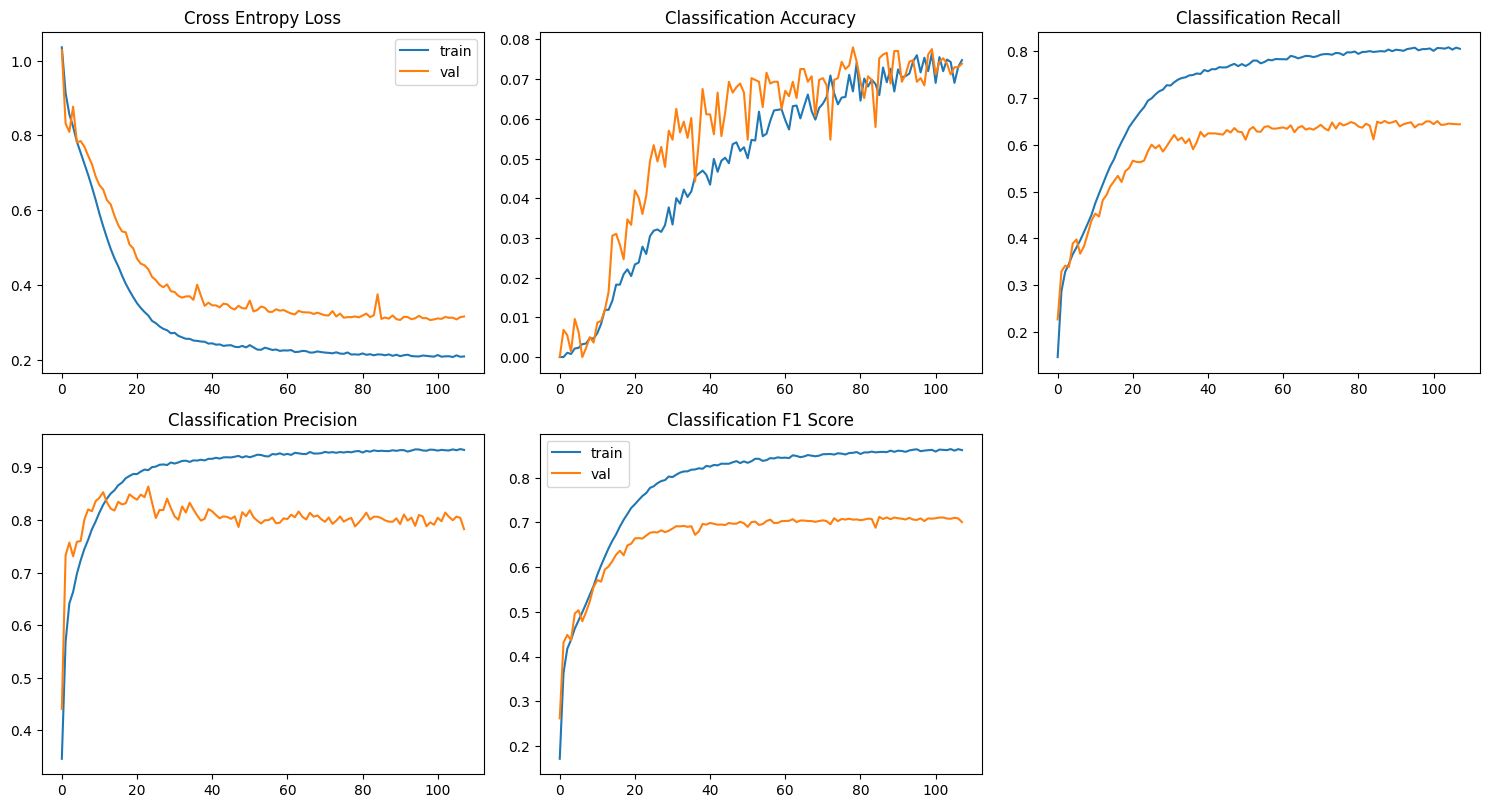

In [41]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set

In [42]:
def plot_histogram(arr):
    max_histogram_missmatchs = 20
    arr_filtered = arr[:max_histogram_missmatchs]
    overMaxMissmachs = arr[max_histogram_missmatchs:]
    print("Filtered array:", arr_filtered)
    # Sum the values > max_histogram_missmatchs (if any exist)
    sum_over_16 = overMaxMissmachs.sum() if len(overMaxMissmachs) > 0 else 0

    # Create a new array for plotting (values ≤ 16 + one "16+" bin)
    new_arr = np.append(arr_filtered, sum_over_16)
    indices = np.arange(len(arr_filtered))
    indices = np.append(indices, str(max_histogram_missmatchs)+"+" )  # Add an index for the "16+" bin
    plt.figure(figsize=(8, 6))  # Wider graph (12 inches width, 6 height)
    # Plot the histogram (bar chart)
    plt.bar(indices, new_arr)

    # Add the numbers on top of each bar
    for i, value in enumerate(new_arr):
        if i == len(arr_filtered):
            plt.text(i, value + 0.1, f'{value}', ha='center', va='bottom')
        plt.text(i, value + 0.1, str(value), ha='center', va='bottom')

    # Customize the plot
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Histogram of Array Values')
    plt.xticks(indices)  # Ensure all indices are shown

    # Display the plot
    plt.show()

100%|██████████| 267/267 [00:14<00:00, 18.80it/s]


All preds shape: torch.Size([2129, 64])
All preds shape: tensor([[ 1,  2,  3,  ...,  9,  8,  7],
        [ 1,  2,  3,  ...,  9,  8,  7],
        [ 1,  2,  3,  ...,  9,  8,  7],
        ...,
        [12, 12, 12,  ..., 12, 12, 12],
        [12, 12, 12,  ..., 12, 12, 12],
        [12, 12, 12,  ..., 12, 12, 12]])
Micro: Recall: 0.9126, Precision: 0.9126, F1: 0.9126
Missing pieces per board: [164  85  95 137 245 289 290 276 207 159  83  42  25  19   7   4   0   0
   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
Filtered array: [164  85  95 137 245 289 290 276 207 159  83  42  25  19   7   4   0   0
   2   0]


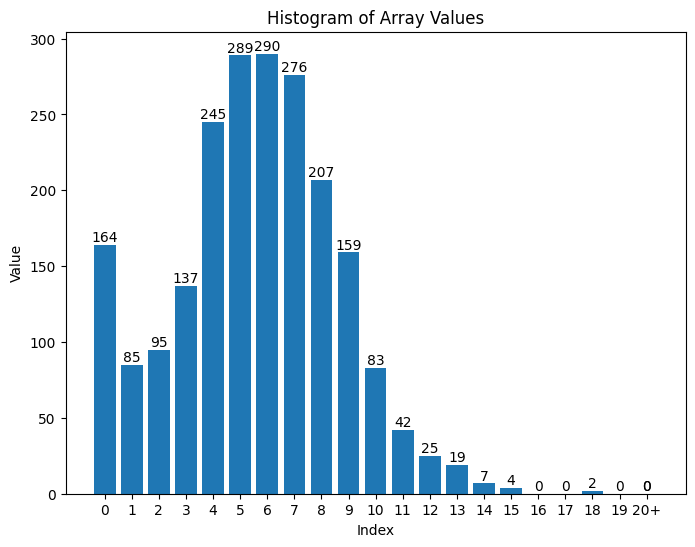

Test accuracy: 0.077, Test recall: 0.639, Test precision: 0.796, Test f1: 0.702


In [50]:
# Load the best model
# TODO


# Evaluate model on test data
# TODO
#free cuda memory
torch.cuda.empty_cache()
model.load_state_dict(torch.load('chess_model_best_model.pth')['model'])
def test(dataloader):
    preds = []
    labels = []
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)

            #probs = F.softmax(pred, dim=1)
            #final_pred = torch.argmax(probs, dim=1)
            #print("Pred shape:", pred.shape)
            predsTmp = pred.view(-1, 64, 13)
            preds.append(predsTmp.argmax(dim=-1).cpu())
            #print(predsTmp.argmax(dim=-1).cpu())
            #print(preds)
            #print(final_pred.cpu().numpy())
            #original_values =y.cpu().argmax(dim=-1) + 1
            labels.append(y.cpu())
        #print(labels.shape,preds.shape)
        all_preds = torch.cat(preds)
        all_labels = torch.cat(labels)
        print("All preds shape:", all_preds.shape)
        print("All preds shape:", all_preds)
        #print("All preds shape:",all_preds.shape,"All labels shape:",all_labels.shape)
        accuracy, recall, precision, f1 = calculate_metrics(all_preds, all_labels)
        missing_list = claculateMissMatchs(all_preds, all_labels)
        print("Missing pieces per board:", missing_list)
        plot_histogram(missing_list)
        return accuracy, recall, precision, f1
accuracy, recall, precision, f1 = test(test_dataloader)
print(f"Test accuracy: {accuracy:.3f}, Test recall: {recall:.3f}, Test precision: {precision:.3f}, Test f1: {f1:.3f}")

  0%|          | 0/267 [00:00<?, ?it/s]

Predictions:


['R', 'N', 'B', 'K', 'Q', 'B', 'N', 'R']
['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p']
['r', 'n', 'b', 'k', 'q', 'b', 'n', 'r']


Ground Truth:


['R', 'N', 'B', 'K', 'Q', 'B', 'N', 'R']
['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p']
['r', 'n', 'b', 'k', 'q', 'b', 'n', 'r']
Micro: Recall: 0.9805, Precision: 0.9805, F1: 0.9805
Accuracy: 0.375, Recall: 0.971, Precision: 0.992, F1: 0.979


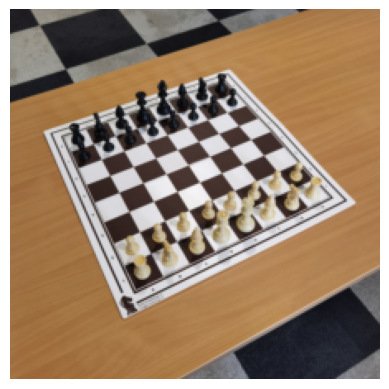

  0%|          | 1/267 [00:00<01:53,  2.35it/s]

Predictions:


['R', '-', 'B', 'K', 'Q', '-', 'N', 'R']
['P', 'P', 'P', '-', 'P', 'P', 'P', 'P']
['-', '-', 'N', 'P', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', 'b', '-', 'p', '-', '-', '-']
['-', '-', 'n', 'p', '-', '-', '-', '-']
['p', 'p', 'p', '-', 'p', 'p', 'p', 'p']
['r', '-', 'b', 'k', 'q', '-', 'n', 'r']


Ground Truth:


['R', '-', 'B', 'K', 'Q', '-', 'N', 'R']
['P', 'P', 'P', '-', 'P', 'P', 'B', 'P']
['-', '-', 'N', 'P', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', 'P', '-']
['-', '-', 'b', '-', 'p', '-', '-', '-']
['-', '-', 'n', 'p', '-', '-', '-', '-']
['p', 'p', 'p', '-', '-', 'p', 'p', 'p']
['r', '-', 'b', 'k', 'q', '-', 'n', 'r']
Micro: Recall: 0.9414, Precision: 0.9414, F1: 0.9414
Accuracy: 0.000, Recall: 0.916, Precision: 0.922, F1: 0.910


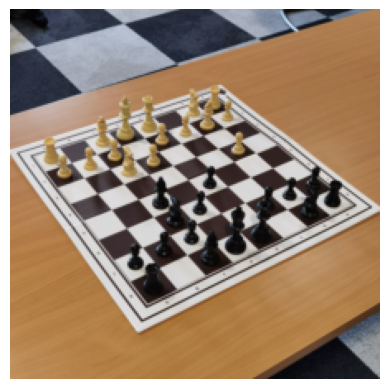

  1%|          | 2/267 [00:00<01:10,  3.78it/s]

Predictions:


['R', '-', '-', 'K', 'Q', '-', '-', 'R']
['P', 'P', 'P', 'B', 'N', '-', 'P', '-']
['-', '-', 'N', 'P', '-', 'N', '-', 'P']
['-', '-', '-', '-', '-', 'P', 'P', '-']
['-', '-', 'b', '-', 'p', '-', '-', '-']
['p', '-', 'n', 'p', 'b', 'n', '-', '-']
['-', 'p', 'p', '-', '-', '-', 'p', 'p']
['r', '-', '-', 'k', 'q', '-', '-', 'r']


Ground Truth:


['R', '-', '-', 'K', 'Q', '-', '-', 'R']
['P', 'P', 'P', 'B', 'P', '-', 'B', '-']
['-', '-', 'N', 'P', '-', 'N', '-', 'P']
['-', '-', '-', '-', '-', 'P', 'P', '-']
['-', '-', 'b', '-', 'p', '-', '-', '-']
['p', '-', 'n', 'p', 'b', 'p', '-', '-']
['-', 'p', 'p', '-', 'n', '-', 'p', 'p']
['r', '-', '-', 'k', 'q', '-', '-', 'r']
Micro: Recall: 0.9453, Precision: 0.9453, F1: 0.9453
Accuracy: 0.000, Recall: 0.903, Precision: 0.922, F1: 0.904


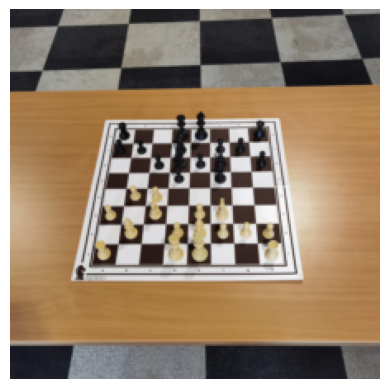

  1%|          | 3/267 [00:00<00:56,  4.64it/s]

Predictions:


['R', 'K', 'B', '-', 'Q', '-', '-', 'R']
['P', 'P', 'P', '-', '-', '-', 'P', '-']
['-', '-', 'P', '-', 'P', 'N', '-', 'P']
['-', '-', '-', 'P', '-', 'P', 'P', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['p', '-', 'n', '-', 'p', 'n', '-', 'p']
['-', 'p', 'p', '-', '-', '-', 'p', '-']
['r', '-', '-', '-', '-', '-', '-', 'r']


Ground Truth:


['-', 'K', 'R', '-', 'Q', '-', '-', 'R']
['P', 'P', 'P', '-', '-', '-', 'B', '-']
['-', '-', 'N', 'P', 'b', 'N', '-', 'P']
['-', '-', '-', '-', 'P', '-', 'P', '-']
['-', '-', '-', '-', 'P', '-', '-', '-']
['p', '-', 'n', 'p', 'b', 'p', '-', 'p']
['-', 'p', 'p', 'q', 'n', '-', 'p', '-']
['-', 'k', 'r', '-', '-', '-', '-', 'r']
Micro: Recall: 0.8926, Precision: 0.8926, F1: 0.8926
Accuracy: 0.000, Recall: 0.642, Precision: 0.736, F1: 0.659


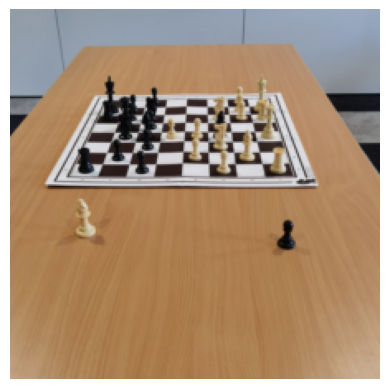

  1%|▏         | 4/267 [00:00<00:49,  5.33it/s]

Predictions:


['-', '-', '-', 'K', '-', '-', '-', 'R']
['P', 'P', 'P', 'B', 'N', '-', '-', '-']
['-', '-', 'N', 'P', '-', 'P', '-', 'P']
['-', '-', '-', '-', 'P', '-', 'P', '-']
['-', '-', '-', '-', 'p', '-', '-', '-']
['p', '-', '-', '-', '-', 'n', '-', 'p']
['-', 'b', 'p', '-', '-', '-', 'p', '-']
['r', 'k', '-', 'r', '-', '-', '-', 'r']


Ground Truth:


['-', '-', '-', 'R', '-', '-', '-', 'R']
['K', 'P', 'P', '-', 'N', '-', 'B', '-']
['-', '-', '-', 'P', 'Q', 'N', '-', 'P']
['-', 'n', '-', '-', 'P', '-', 'P', '-']
['-', '-', '-', '-', 'p', '-', '-', '-']
['p', '-', '-', '-', '-', 'p', '-', 'p']
['-', 'p', 'p', 'q', 'n', '-', 'p', '-']
['-', 'k', '-', 'r', '-', '-', '-', 'r']
Micro: Recall: 0.8652, Precision: 0.8652, F1: 0.8652
Accuracy: 0.000, Recall: 0.460, Precision: 0.532, F1: 0.477


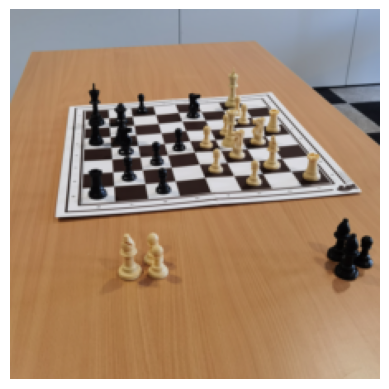

  2%|▏         | 5/267 [00:01<00:44,  5.83it/s]

Predictions:


['-', '-', '-', '-', '-', '-', '-', 'R']
['-', 'P', '-', '-', 'N', '-', '-', '-']
['-', '-', '-', 'P', 'B', '-', '-', 'P']
['-', '-', '-', '-', 'P', '-', 'P', 'p']
['-', 'p', '-', '-', 'p', '-', 'p', '-']
['p', '-', '-', '-', '-', 'p', '-', 'p']
['-', 'p', 'p', '-', 'q', '-', '-', '-']
['-', 'k', '-', 'r', '-', '-', '-', 'r']


Ground Truth:


['-', '-', '-', 'R', '-', '-', '-', 'R']
['-', 'P', '-', '-', 'N', '-', 'B', '-']
['-', 'K', '-', 'P', 'n', '-', '-', 'P']
['-', '-', '-', '-', 'P', '-', 'P', 'N']
['-', 'P', '-', '-', 'p', '-', 'p', '-']
['p', '-', '-', '-', '-', 'p', '-', 'p']
['-', 'p', 'p', '-', 'n', '-', '-', '-']
['-', 'k', '-', 'r', '-', '-', '-', 'r']
Micro: Recall: 0.9180, Precision: 0.9180, F1: 0.9180
Accuracy: 0.000, Recall: 0.546, Precision: 0.587, F1: 0.560


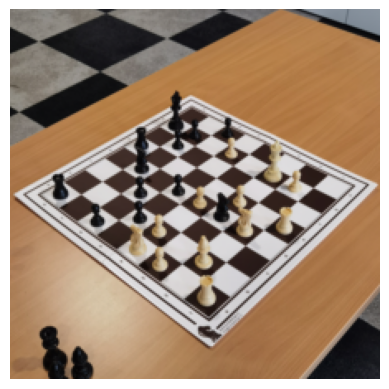

  2%|▏         | 5/267 [00:01<01:01,  4.27it/s]


In [51]:
torch.cuda.empty_cache()
def results_analyse(dataloader):
    preds = []
    labels = []
    results = 5
    with torch.no_grad():  # Disable gradient calculation
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)

            #probs = F.softmax(pred, dim=1)
            #final_pred = torch.argmax(probs, dim=1)
            predsTmp = pred.view(-1, 64, 13).argmax(dim=-1).cpu()
            print("Predictions:\n\n")
            print_readable_board(predsTmp[0])
            print("\n\nGround Truth:\n\n")
            print_readable_board(y.cpu()[0])
            #print(pred.cpu().shape, y.cpu().shape)
            #print(pred1)
            accuracy, recall, precision, f1 = calculate_metrics(predsTmp, y.cpu())
            print(f"Accuracy: {accuracy:.3f}, Recall: {recall:.3f}, Precision: {precision:.3f}, F1: {f1:.3f}")
            #print(pred.cpu())
            #print(y.cpu())
            imgs = X.cpu()
            imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
            plt.imshow(imgs[0])
            plt.axis('off')
            plt.show()
            results -= 1
            if results <0:
                break
results_analyse(test_dataloader)

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?